<a href="https://colab.research.google.com/github/ManojKesani/knowledge_distill_image_retrival/blob/main/resnet_teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
# (ds_train,ds_test),ds_info = stl10

In [ ]:
(x_train,y_train_ ),(x_test,y_test_) = tfds.as_numpy(tfds.load('stl10', split=['train','test'], as_supervised=True, shuffle_files=True,batch_size=-1))

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train_)
y_test = to_categorical(y_test_)

In [ ]:
from keras.utils import Sequence
import albumentations as A
import cv2


batch_size = 16
class DataGenerator(Sequence):
  def __init__(self, x , y ,batch_size, transform = None):
    self.data = x
    self.batch_size = batch_size
    self.transform = transform
    self.labels = y

  def __len__(self):
    return int(np.floor(len(self.data) / self.batch_size))

  def __getitem__(self,index):
    # print('working on batch ',index)
    imgs = self.data[index*self.batch_size:(index+1)*self.batch_size]
    labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]

    x = np.empty((batch_size, 96, 96, 3), dtype=np.float32)
    y = np.empty((batch_size,10))
    for idx, foo in enumerate(zip(imgs,labels)):

      y[idx] = foo[1]
      
      if self.transform is not None:
        image = foo[0]
        transformed = transform(image=image)
        transformed_image = transformed["image"]

        x[idx] = transformed_image/255.

      else:
        x[idx] = foo[0]/255.

    return x , y
 
train_data = DataGenerator(x_train,y_train, batch_size)
validation_data = DataGenerator(x_test,y_test, batch_size)

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(),
    A.RandomSizedCrop([80,80],96,96),
    A.Transpose()
])

train_data = DataGenerator(x_train,y_train, batch_size,transform=transform)
validation_data = DataGenerator(x_test,y_test, batch_size,transform=transform)

In [ ]:
img,label = next(iter(train_data))

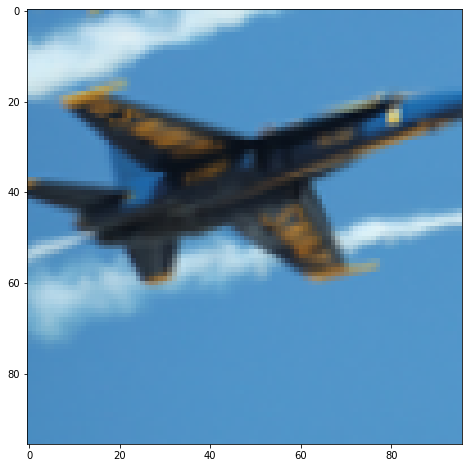

In [ ]:
plt.imshow(img[1])

In [ ]:
from keras import layers
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.models import Model
from keras.regularizers import l2


def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer


def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer


def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out


def ResNet18(classes, input_shape, weight_decay=1e-4):
    input = Input(shape=input_shape)
    x = input
    # x = conv2d_bn_relu(x, filters=64, kernel_size=(7, 7), weight_decay=weight_decay, strides=(2, 2))
    # x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),  padding='same')(x)
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name='ResNet18')
    return model


def ResNetForCIFAR10(classes, name, input_shape, block_layers_num, weight_decay):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    for i in range(block_layers_num):
        x = ResidualBlock(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    for i in range(block_layers_num - 1):
        x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    for i in range(block_layers_num - 1):
        x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(8, 8), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name=name)
    return model


def ResNet20ForCIFAR10(classes, input_shape, weight_decay):
    return ResNetForCIFAR10(classes, 'resnet20', input_shape, 3, weight_decay)


def ResNet32ForCIFAR10(classes, input_shape, weight_decay):
    return ResNetForCIFAR10(classes, 'resnet32', input_shape, 5, weight_decay)


def ResNet56ForCIFAR10(classes, input_shape, weight_decay):
    return ResNetForCIFAR10(classes, 'resnet56', input_shape, 9, weight_decay)

In [ ]:
from keras import losses
from keras import optimizers

weight_decay = 1e-4
lr = 0.01
num_classes = 10
resnet20 = ResNet56ForCIFAR10(input_shape=(96, 96, 3), classes=num_classes, weight_decay=weight_decay)
opt = optimizers.Adam(lr=lr)
resnet20.compile(optimizer=opt,
                 loss=losses.categorical_crossentropy,
                 metrics=['accuracy'])
# resnet20.summary()

In [ ]:
!rm -r /content/output

In [ ]:
from keras.callbacks import LearningRateScheduler ,ReduceLROnPlateau

# def lr_scheduler(epoch):
#     new_lr = lr * (0.1 ** (epoch // 5))
#     print('new lr:%.2e' % new_lr)
#     return new_lr 

# reduce_lr = LearningRateScheduler(lr_scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6, verbose=1)


In [ ]:
from keras.callbacks import TensorBoard,LambdaCallback
train_lr_callback = LambdaCallback( on_epoch_begin= lambda epoch,logs: print("LearningRate of %e" % (K.eval(resnet20.optimizer._decayed_lr('float32').numpy())) ))

history = resnet20.fit(x_train,y_train,
                                    epochs=200,
                                    callbacks=[reduce_lr,TensorBoard(log_dir='/content/output'),train_lr_callback],
                                    validation_data=(x_test, y_test)
                      #  , verbose=1
                                    )

Epoch 1/200
LearningRate of 1.000000e-02
157/157 [==============================] - 43s 242ms/step - loss: 4.1823 - accuracy: 0.1123 - val_loss: 494.1436 - val_accuracy: 0.1036
Epoch 2/200
LearningRate of 1.000000e-02
157/157 [==============================] - 36s 227ms/step - loss: 2.4480 - accuracy: 0.2733 - val_loss: 2.4960 - val_accuracy: 0.2492
Epoch 3/200
LearningRate of 1.000000e-02
157/157 [==============================] - 36s 228ms/step - loss: 2.1087 - accuracy: 0.3316 - val_loss: 2.2485 - val_accuracy: 0.2848
Epoch 4/200
LearningRate of 1.000000e-02
157/157 [==============================] - 36s 228ms/step - loss: 1.9169 - accuracy: 0.3809 - val_loss: 2.1866 - val_accuracy: 0.3203
Epoch 5/200
LearningRate of 1.000000e-02
157/157 [==============================] - 36s 227ms/step - loss: 1.8007 - accuracy: 0.4252 - val_loss: 1.8447 - val_accuracy: 0.4051
Epoch 6/200
LearningRate of 1.000000e-02
157/157 [==============================] - 36s 227ms/step - loss: 1.6921 - accurac

In [ ]:
# %reload_ext tensorboard
%tensorboard --logdir /content/output

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import tensorflow as tf 
from keras import backend as k
import os


In [ ]:
import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import cv2

class CIFAR10Data(object):
    def __init__(self):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = cifar10.load_data()
        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        print('CIFAR10 Training data shape:', self.x_train.shape)
        print('CIFAR10 Training label shape', self.y_train.shape)
        print('CIFAR10 Test data shape', self.x_test.shape)
        print('CIFAR10 Test label shape', self.y_test.shape)

    def get_stretch_data(self, subtract_mean=True):
        """
        reshape X each image to row vector, and transform Y to one_hot label.
        :param subtract_mean:Indicate whether subtract mean image.
        :return: x_train, one_hot_y_train, x_test, one_hot_y_test
        """
        num_classes = len(self.classes)
        # x_train = np.reshape(self.x_train, (self.x_train.shape[0], -1)).astype('float64')
        x_train = np.reshape(self.x_train, (self.x_train.shape[0], -1)).astype('float16')
        y_train = keras.utils.to_categorical(self.y_train, num_classes)

        # x_test = np.reshape(self.x_test, (self.x_test.shape[0], -1)).astype('float64')
        x_test = np.reshape(self.x_test, (self.x_test.shape[0], -1)).astype('float16')
        y_test = keras.utils.to_categorical(self.y_test, num_classes)

        if subtract_mean:
            mean_image = np.mean(x_train, axis=0).astype('uint8')
            x_train -= mean_image
            x_test -= mean_image
            # print(x_mean[:10])
            # plt.figure(figsize=(4, 4))
            # plt.imshow(x_mean.reshape((32, 32, 3)))
            # plt.show()

        return x_train, y_train, x_test, y_test

    def get_data(self, subtract_mean=True, output_shape=None):
        """
        The data is not reshaped, keep 3 channel.
        :param subtract_mean:Indicate whether subtract mean image.
        :param output_shape:Indicate whether resize image
        :return: x_train, one_hot_y_train, x_test, one_hot_y_test
        """
        num_classes = len(self.classes)
        x_train = self.x_train
        x_test = self.x_test
        # if output_shape:resize
        #     x_train = np.array([cv2.resize(img, output_shape) for img in self.x_train])
        #     x_test = np.array([cv2.(img, output_shape) for img in self.x_test])

        x_train = x_train.astype('float16')
        y_train = keras.utils.to_categorical(self.y_train, num_classes)

        x_test = x_test.astype('float16')
        y_test = keras.utils.to_categorical(self.y_test, num_classes)

        if subtract_mean:
            mean_image = np.mean(x_train, axis=0)
            x_train -= mean_image
            x_test -= mean_image
        return x_train, y_train, x_test, y_test


def plot_cifar10(cifar_data, num_sample_per_class):
    """
    random select num_sample_per_class to plot
    """
    num_classes = len(cifar_data.classes)

    plt.figure()
    for y, cls in enumerate(cifar_data.classes):
        cls_indices = np.flatnonzero(cifar_data.y_train == y)
        samples_indices = np.random.choice(cls_indices, num_sample_per_class, replace=False)
        samples = cifar_data.x_train[samples_indices]
        for x, sample in enumerate(samples):
            # subplot index count from 1
            plt_idx = x * num_classes + y + 1
            plt.subplot(num_sample_per_class, num_classes, plt_idx)
            plt.imshow(sample)
            plt.axis('off')
            if x == 0:
                plt.title(cls)
    plt.show()

In [ ]:


# get data
cifar10_data = CIFAR10Data()
x_train, y_train, x_test, y_test = cifar10_data.get_data(subtract_mean=True)

num_train = int(x_train.shape[0] * 0.9)
num_val = x_train.shape[0] - num_train
mask = list(range(num_train, num_train+num_val))
x_val = x_train[mask]
y_val = y_train[mask]

mask = list(range(num_train))
x_train = x_train[mask]
y_train = y_train[mask]

CIFAR10 Training data shape: (50000, 32, 32, 3)
CIFAR10 Training label shape (50000, 1)
CIFAR10 Test data shape (10000, 32, 32, 3)
CIFAR10 Test label shape (10000, 1)


In [ ]:
from keras import layers
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.models import Model
from keras.regularizers import l2


def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer


def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer


def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out


def ResNet18(classes, input_shape, weight_decay=1e-4):
    input = Input(shape=input_shape)
    x = input
    # x = conv2d_bn_relu(x, filters=64, kernel_size=(7, 7), weight_decay=weight_decay, strides=(2, 2))
    # x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),  padding='same')(x)
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name='ResNet18')
    return model


def ResNetForCIFAR10(classes, name, input_shape, block_layers_num, weight_decay):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    for i in range(block_layers_num):
        x = ResidualBlock(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    for i in range(block_layers_num - 1):
        x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    for i in range(block_layers_num - 1):
        x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(8, 8), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name=name)
    return model


def ResNet20ForCIFAR10(classes, input_shape, weight_decay):
    return ResNetForCIFAR10(classes, 'resnet20', input_shape, 3, weight_decay)


def ResNet32ForCIFAR10(classes, input_shape, weight_decay):
    return ResNetForCIFAR10(classes, 'resnet32', input_shape, 5, weight_decay)


def ResNet56ForCIFAR10(classes, input_shape, weight_decay):
    return ResNetForCIFAR10(classes, 'resnet56', input_shape, 9, weight_decay)

In [ ]:
from keras import losses
from keras import optimizers

weight_decay = 1e-4
lr = 0.002
num_classes = 10
resnet20 = ResNet20ForCIFAR10(input_shape=(32, 32, 3), classes=num_classes, weight_decay=weight_decay)
opt = optimizers.Adam(lr=lr)
resnet20.compile(optimizer=opt,
                 loss=losses.categorical_crossentropy,
                 metrics=['accuracy'])
# resnet20.summary()

In [ ]:
from keras.callbacks import LearningRateScheduler ,ReduceLROnPlateau

# def lr_scheduler(epoch):
#     new_lr = lr * (0.1 ** (epoch // 5))
#     print('new lr:%.2e' % new_lr)
#     return new_lr 

# reduce_lr = LearningRateScheduler(lr_scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6, verbose=1)


In [ ]:
datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                # rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=4,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=4,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False,  # randomly flip images
            )

train_gen = datagen.flow(x_train, y_train, batch_size=128)



In [ ]:
!rm -r /content/output

In [ ]:
from keras.callbacks import TensorBoard,LambdaCallback
train_lr_callback = LambdaCallback( on_epoch_begin= lambda epoch,logs: print("LearningRate of %e" % (K.eval(resnet20.optimizer._decayed_lr('float32').numpy())) ))

history = resnet20.fit(train_gen,
                                    epochs=200,
                                    callbacks=[reduce_lr,TensorBoard(log_dir='/content/output'),train_lr_callback],
                                    validation_data=(x_val, y_val)
                      #  , verbose=1
                                    )

In [ ]:
resnet20.evaluate(x_test,y_test)

313/313 [==============================] - 1s 5ms/step - loss: 0.4645 - accuracy: 0.8905


[0.4645436108112335, 0.890500009059906]

In [ ]:
resnet20.save('resnet20_cifar10.h5')

In [ ]:
model = 